# 2020 P-ADA-wan ADA Project: Milestone 4


This notebook is part of the Fall 2020 EPFL ADA course. On this notebook, we'll try to extend the Tesco's paper. 

# Part 1 : Machine Learning 


We will first try to create correct Machine Learning algorithms which will link Tesco's grocery data with children obesity, then extract meaningful informations from our results.

## Loading the Dataset

As usual, we will import our libraries and our dataset in our notebook. The data was taken from [The official paper's dataset](https://figshare.com/collections/Tesco_Grocery_1_0/4769354/2)

In [302]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
%matplotlib inline
from scipy import stats
from sklearn import tree
from sklearn import svm
from sklearn import linear_model, model_selection
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

In [7]:
# Loading the files into DataFrames
obesity = pd.read_csv(Path.cwd() / "data" / "child_obesity_london_ward_2013-2014.csv")
grocery = pd.read_csv(Path.cwd() / "data" / "year_osward_grocery.csv")

In [8]:
# Let's have a closer look at the dataframes
grocery.head(5)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


In [9]:
obesity.head(5)

,area_id,number_reception_measured,number_y6_measured,prevalence_overweight_reception,prevalence_overweight_y6,prevalence_obese_reception,prevalence_obese_y6
0,E05000026,712,441,0.259831461,0.387755102,0.133426966,0.247165533
1,E05000027,592,427,0.224662162,0.402810304,0.099662162,0.259953162
2,E05000028,665,499,0.24962406,0.466933868,0.123308271,0.29258517
3,E05000029,484,362,0.241735537,0.422651934,0.128099174,0.245856354
4,E05000030,446,320,0.257847534,0.378125,0.125560538,0.215625


In [10]:
joined_df = grocery.merge(obesity, how='inner', on='area_id')

In [11]:
print(f"We have {len(grocery.columns)} potentials predictors and {len(obesity.columns)} potential labels, for {len(joined_df)} datapoints")

We have 202 potentials predictors and 7 potential labels, for 544 datapoints


### Choosing the correct columns

As we see with the output of the previous cell, we have a problem. Indeed, we have too many columns for our number of datapoints. With 202 predictors for 544 datapoints, our model will not represent properly the reality.

Hence, we should select the columns that will be meaningful to predict our output. But actually, what's our output ? 

When we read the [Tesco's paper reference](https://figshare.com/articles/dataset/Validation_data_obesity_diabetes_/7796672?backTo=/collections/Tesco_Grocery_1_0/4769354) we see that we have 4 interesting columns, which represent the prevalence of overweight and obese for children of year 6 and children of year 4 and 5.

As the data for the overweight children will be more sparse than the data for the obese children (obese children will be included in the overweight ones -> we will always have a greater value for overweight children than for obese), we'll choose to predict the overweight children. We'll also choose to select the data for year 6 children, as we tend to give more liberty to food consumption's of children when they age.

So our labeled data will be the column "prevalence_overweight_y6".

As we take data from londonese children, we'll follow [the guidelines of the National Health Service](https://www.nhs.uk/conditions/obesity/causes/) to select our predictors. We can note that there are four points that we can extract from the dataset that causes obesity: calories, fat, sugar and alcohol. As children of 6 years old are not likely to drink alcohol, we will focus on the 3 columns _fat_, _sugar_ and _energy_tot_

## First try : follow NHS guidelines on nutrients

In [12]:
data_1 = joined_df[["fat", "sugar", "energy_tot", "prevalence_overweight_y6"]]
data_1.head(5)

,fat,sugar,energy_tot,prevalence_overweight_y6
0,9.488797,10.966213,187.114757,0.387755102
1,9.733634,10.514427,188.638145,0.402810304
2,9.216310,10.690272,186.861792,0.466933868
3,9.700137,12.938606,190.783934,0.422651934
4,9.381808,11.332898,188.136201,0.378125


We have obtained the DataFrame containing the informations we wanted to.

We now have to preprocess our input. To this end, we will remove the NA values from the target, standardize our predictor, and split the original data into a train and a test set.

In [13]:
# Sanitazing NA data. As they are considered as string in the original dataset, we have to remove them as string, then convert it to float.
data_1 = data_1[data_1["prevalence_overweight_y6"] != "na"]

X_1 = data_1[["fat", "sugar", "energy_tot"]]
Y_1 = data_1["prevalence_overweight_y6"].astype(float)

X_1 = (X_1 - np.mean(X_1, axis=0)) / np.std(X_1, axis=0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.3, random_state=0)

## Creating our Machine Learning Models

Now that we have our data prepared, we will now compute different ML algorithms in order to find out the one that perform the best.

In our case, we will use the [R-squared](https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/) to estimate the efficiency of our ML algorithm. To give a quick recap, the R-squared represent the value obtained when comparing the residual sum of squares (SSres) with total sum of squares(SStot). If the model fit the data perfectly, the value obtained will be 1. If we create an average line and present it as our model, the value obtained will be 0. Hence, everything between 0 and 1 means that our model is better than drawing a straight line, and everything below 0 means that our model is worse than an average line (which is not what we want to have).

At the same time, we will get the MSE error, to have a second comparison points

In [124]:
# Linear Regression
def linear_regression(X_train, y_train, X_test, y_test):
    linear_model = LinearRegression()
    linear_model = linear_model.fit(X_train, y_train)
    linear_model_prediction = linear_model.predict(X_test)

    print(f"Mean squared error: {mean_squared_error(y_test, linear_model_prediction):.3f}")
    print(f"R2 score: {r2_score(y_test, linear_model_prediction):.3f}")
    print(f"coefs {linear_model.coef_}")
    return linear_model_prediction


# Ridge model
def ridge_model(X_train, y_train, X_test, y_test):
    alphas = np.arange(0.1, 10, 0.1)
    best_r2_score_ridge = -99
    mse_score_related_ridge = 0
    best_alpha = 0


    for alpha in alphas:
        ridge_model = linear_model.Ridge(alpha=alpha)
        ridge_model.fit(X_train, y_train)
        ridge_model_prediction = ridge_model.predict(X_test)
        r2 = r2_score(y_test, ridge_model_prediction)
        mse = mean_squared_error(y_test, ridge_model_prediction)
        if r2 > best_r2_score_ridge:
            best_r2_score_ridge = r2
            mse_score_related_ridge = mse
            best_alpha = alpha

    print(f"A ridge model obtain the best r2 score when the lasso alpha is {best_alpha}. The r2 score is {best_r2_score_ridge:.3f} and the related mse score is {mse_score_related_ridge:.3f}")
    
def svm_model(X_train, y_train, X_test, y_test):
    svm_model = svm.SVR()
    svm_model = svm_model.fit(X_train, y_train)
    svm_model_prediction = svm_model.predict(X_test)

    print(f"SVM: Mean squared error: {mean_squared_error(y_test, svm_model_prediction):.3f}")
    print(f"SVM: R2 score: {r2_score(y_test, svm_model_prediction):.3f}")

    
def tree_model(X_train, y_train, X_test, y_test):
    tree_model = tree.DecisionTreeRegressor()
    tree_model = tree_model.fit(X_train, y_train)
    tree_model_prediction = tree_model.predict(X_test)

    print(f"Decision Tree: Mean squared error: {mean_squared_error(y_test, tree_model_prediction):.3f}")
    print(f"Decision Tree: R2 score: {r2_score(y_test, tree_model_prediction):.3f}")

def GBR_model(X_train, y_train, X_test, y_test):
    GBR_model = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    GBR_model = GBR_model.fit(X_train, y_train)
    GBR_model_prediction = GBR_model.predict(X_test)

    print(f"Gradient Boosting Regressor: Mean squared error: {mean_squared_error(y_test, GBR_model_prediction):.3f}")
    print(f"Gradient Boosting Regressor::R2 score: {r2_score(y_test, GBR_model_prediction):.3f}")
    
def ADA_model(X_train, y_train, X_test, y_test):
    ADA_model = AdaBoostRegressor(n_estimators=10)
    ADA_model = ADA_model.fit(X_train, y_train)
    ADA_model_prediction = ADA_model.predict(X_test)

    print(f"ADA: Mean squared error: {mean_squared_error(y_test, ADA_model_prediction):.3f}")
    print(f"ADA: R2 score: {r2_score(y_test, ADA_model_prediction):.3f}")

### Let's now try our ML algorithm on our data ! 

In [15]:
linear_regression(X_train_1, y_train_1, X_test_1, y_test_1)
ridge_model(X_train_1, y_train_1, X_test_1, y_test_1)
svm_model(X_train_1, y_train_1, X_test_1, y_test_1)
tree_model(X_train_1, y_train_1, X_test_1, y_test_1)
GBR_model(X_train_1, y_train_1, X_test_1, y_test_1)
ADA_model(X_train_1, y_train_1, X_test_1, y_test_1)

Mean squared error: 0.004
R2 score: -0.064
coefs [-0.01662939 -0.01028952  0.02897609]
A ridge model obtain the best r2 score when the lasso alpha is 9.9. The r2 score is -0.049 and the related mse score is 0.004
SVM: Mean squared error: 0.004
SVM: R2 score: -0.256
Decision Tree: Mean squared error: 0.008
Decision Tree: R2 score: -1.234
Gradient Boosting Regressor: Mean squared error: 0.004
Gradient Boosting Regressor::R2 score: -0.233
ADA: Mean squared error: 0.004
ADA: R2 score: -0.088


### Analysis of the results
It seems that the model performs poorly. Indeed, the r2 score is almost always negative, except for the ADA algorithm (can we state that ADA is the most efficient way to do machine learning then ? :D), when the r2 score is almost null at 0.04.

So our initial predictors do not perform well with our target. Before giving it up, let's try to still follow the NHS guidelines which points calories, sugar and fat for obesity causes.

## Second try : NHS guidelines, but with relative values instead of absolutes

This time, we'll try to perform our model with _f\_energy\_sugar_ and _f\_energy\_fat_ instead of _sugar_ and _fat_. These predictors represent the proportion of energy of fat and sugar in the average product bought by Tesco's customer, as opposed to the previous predictors which represented the absolute value of those nutrients in the average food product.

### Data processing

We will select the corresponding columns from the DataFrame, and preprocess them.

In [16]:
data_2 = joined_df[["f_energy_fat", "f_energy_sugar", "energy_tot", "prevalence_overweight_y6"]]
data_2.head(5)

,f_energy_fat,f_energy_sugar,energy_tot,prevalence_overweight_y6
0,0.456400,0.234428,187.114757,0.387755102
1,0.464395,0.222954,188.638145,0.402810304
2,0.443894,0.228838,186.861792,0.466933868
3,0.457592,0.271272,190.783934,0.422651934
4,0.448804,0.240951,188.136201,0.378125


In [17]:
# Sanitazing NA data. As they are considered as string in the original dataset, we have to remove them as string, then convert it to float.
data_2 = data_2[data_2["prevalence_overweight_y6"] != "na"]

X_2 = data_2[["f_energy_fat", "f_energy_sugar", "energy_tot"]]
Y_2 = data_2["prevalence_overweight_y6"].astype(float)

X_2 = (X_2 - np.mean(X_2, axis=0)) / np.std(X_2, axis=0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.3, random_state=0)

### Applying ML algorithms 

Now that we have processed our data, let's run our ML algorithms on it.

In [18]:
linear_regression(X_train_2, y_train_2, X_test_2, y_test_2)
ridge_model(X_train_2, y_train_2, X_test_2, y_test_2)
svm_model(X_train_2, y_train_2, X_test_2, y_test_2)
tree_model(X_train_2, y_train_2, X_test_2, y_test_2)
GBR_model(X_train_2, y_train_2, X_test_2, y_test_2)
ADA_model(X_train_2, y_train_2, X_test_2, y_test_2)

Mean squared error: 0.004
R2 score: -0.061
coefs [-0.01059494 -0.00627236  0.00633608]
A ridge model obtain the best r2 score when the lasso alpha is 9.9. The r2 score is -0.058 and the related mse score is 0.004
SVM: Mean squared error: 0.004
SVM: R2 score: -0.276
Decision Tree: Mean squared error: 0.008
Decision Tree: R2 score: -1.168
Gradient Boosting Regressor: Mean squared error: 0.004
Gradient Boosting Regressor::R2 score: -0.259
ADA: Mean squared error: 0.004
ADA: R2 score: -0.101


### Analysing the result 

Even though after trying with relative values instead of absolute ones, the model still poorly fit on our dataset.

It means that there is little but no correlation between on one side the relative or absolute values of fat / sugar and the total amount of energy of the average product bought at Tesco Grocery, and on the other side the 6 years old children overweight prevalence.

Even though we can be disappointed because we wanted to point out a link that doesn't seem to exist, let's try to find out the different reasons that might explain this lack of correlation.

To this end, I will use the different results of the Tesco paper figure 5 (the spearman correlation between nutrients and health problems), and the food-related informations of the NHS for [Type-2 diabetes] (https://www.nhs.uk/conditions/type-2-diabetes/food-and-keeping-active/) and [obesity] (https://www.nhs.uk/conditions/obesity/causes/)

+ We can note that there is no statistically significant correlations between overweight children (year 6) and energy, fat and sugar. 
+ We can note that NHS warn about the amount of calories eaten for obesity, but not for type 2 diabetes.
+ This result might be due to the fact that physical activity is more important to prevent obesity than type-2 diabetes, which will be more linked to the alimentation. Indeed, we gain weight when the amount of calories burned (which increases with physical activity) is less than the amount of calories ingested. On the other hand, it seems that diet and [especially glucose](https://www.mayoclinic.org/diseases-conditions/type-2-diabetes/symptoms-causes/syc-20351193) play a decisve role to have type 2 diabetes. Hence, the fact that we don't have the physical activity in our study might be more dommageable for the obesity risk than for diabetes.
+ Even though more and more children begin to have type-2 diabetes, this medical condition is often detected when the patients are adults. It means that they have kept their eating habits in a period of time way more long, which means that their eating habits have "beaten" their natural health conditions, which might be not the case for children (some babies are born with more weight than other naturally)
+ As obesity is due to have more calories ingested than burned, the total energy of the "average product" might not be that representative, as we don't know how much "average product" will be eaten by the children
+ As they are children, it is the parents that decide what the family will buy at the grocery store. But the children might eat differently than their parents, but we are not able to know it with our dataset. For example, we don't know if it's the children, or the parents that will eat the sweets.

## Third try: using food category

Now that we have shown that there is little but no correlations between the nutrients of the average product bought at Tesco and children overweight prevalence at 6 y.o., we will still try to extract a link between the Tesco dataset and the children obesity one.

On this try, we will try to create a link between the food categories and the children obesity. From the NHS guidelines, it makes sense that some categories like treated food or sweets will influence children overweight

### Data processing

Let's process the data, by firstly selecting the corresponding columns

In [19]:
columns_categories = [a for a in joined_df if (a.startswith("f_") and not ('energy' in a) and not('weight' in a))]
columns_categories

['f_beer',
 'f_dairy',
 'f_eggs',
 'f_fats_oils',
 'f_fish',
 'f_fruit_veg',
 'f_grains',
 'f_meat_red',
 'f_poultry',
 'f_readymade',
 'f_sauces',
 'f_soft_drinks',
 'f_spirits',
 'f_sweets',
 'f_tea_coffee',
 'f_water',
 'f_wine']

In [20]:
# As it seems unlikely that 6 y.o. children drink wine, beer or spirits, we'll drop those columns.

columns_categories.remove('f_beer')
columns_categories.remove('f_spirits')
columns_categories.remove('f_wine')

In [21]:
# Then, we'll process the data as usual. Select the columns from the original dataset, filter the valid data, split the data into predictors and targets,
# standardize the data, and split it into train and test set.

columns_categories.append("prevalence_overweight_y6")

data_category = joined_df[columns_categories]
data_category = data_category[data_category["prevalence_overweight_y6"] != "na"]

X_category = data_category[columns_categories[:-1]]
Y_category = data_category["prevalence_overweight_y6"].astype(float)

X_category = (X_category - np.mean(X_category, axis=0)) / np.std(X_category, axis=0)

X_train_category, X_test_category, y_train_category, y_test_category = train_test_split(X_category, Y_category, test_size=0.3, random_state=0)

### Machine learning models

Now that we have preprocess our data, we'll apply our ML algorithms on it.

In [22]:
linear_regression(X_train_category, y_train_category, X_test_category, y_test_category)
ridge_model(X_train_category, y_train_category, X_test_category, y_test_category)
svm_model(X_train_category, y_train_category, X_test_category, y_test_category)
tree_model(X_train_category, y_train_category, X_test_category, y_test_category)
GBR_model(X_train_category, y_train_category, X_test_category, y_test_category)
ADA_model(X_train_category, y_train_category, X_test_category, y_test_category)

Mean squared error: 0.002
R2 score: 0.334
coefs [ 0.02897543  0.00719029 -0.01684575  0.02480146  0.02697712  0.01807109
  0.02448877  0.00785403  0.0064194   0.00201866  0.02852251  0.0318379
 -0.0029601   0.03510894]
A ridge model obtain the best r2 score when the lasso alpha is 9.9. The r2 score is 0.364 and the related mse score is 0.002
SVM: Mean squared error: 0.003
SVM: R2 score: 0.128
Decision Tree: Mean squared error: 0.005
Decision Tree: R2 score: -0.311
Gradient Boosting Regressor: Mean squared error: 0.003
Gradient Boosting Regressor::R2 score: 0.231
ADA: Mean squared error: 0.003
ADA: R2 score: 0.241


### Analysis

Finally, we found a model that fit wells the data. The R2 score for the linear regression is 0.334, which means that the model fits the data better than if we draw the average line.

Thus, there is a relation between the type of aliments one's buy at a grocery store and the children overweight prevalence. Let's try to dig it further in a linear regression analysis to analysze the data.

In [23]:
df_1 = joined_df[joined_df["prevalence_overweight_y6"] != "na"].copy()
df_1["prevalence_overweight_y6"] = df_1["prevalence_overweight_y6"].astype(float)
mod = smf.ols(formula='prevalence_overweight_y6 ~  f_dairy + f_eggs + f_fats_oils + f_fish + f_fruit_veg + f_grains + f_meat_red + f_poultry + f_readymade + f_sauces + f_soft_drinks + f_sweets', data= df_1)

res = mod.fit()

# coefficients
variables_1 = res.params.index

coefficients_1 = res.params.values

# p-values
p_values_1 = res.pvalues

# standard errors
standard_errors_1 = res.bse.values
stats_1 = pd.DataFrame({'variables_1': variables_1, 'coef_1': coefficients_1, 'p_values_1': p_values_1, 'std_err_1': standard_errors_1})

print(res.summary())

                               OLS Regression Results                               
Dep. Variable:     prevalence_overweight_y6   R-squared:                       0.486
Model:                                  OLS   Adj. R-squared:                  0.474
Method:                       Least Squares   F-statistic:                     41.17
Date:                      Fri, 18 Dec 2020   Prob (F-statistic):           8.87e-68
Time:                              15:33:13   Log-Likelihood:                 899.15
No. Observations:                       536   AIC:                            -1772.
Df Residuals:                           523   BIC:                            -1717.
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [24]:
stats_1[stats_1["p_values_1"] < 0.05]

,variables_1,coef_1,p_values_1,std_err_1
f_dairy,f_dairy,1.119697,6.934815e-03,0.413066
f_fish,f_fish,5.540837,2.558151e-09,0.913846
f_grains,f_grains,0.953691,7.819929e-03,0.357181
f_meat_red,f_meat_red,1.250866,4.179629e-02,0.613002
f_poultry,f_poultry,3.503602,3.023843e-03,1.176003
f_readymade,f_readymade,-1.736323,1.181007e-04,0.447581
f_sauces,f_sauces,-3.069718,1.917792e-02,1.306632
f_soft_drinks,f_soft_drinks,3.860187,5.274776e-11,0.575825
f_sweets,f_sweets,0.836434,7.312735e-03,0.310619


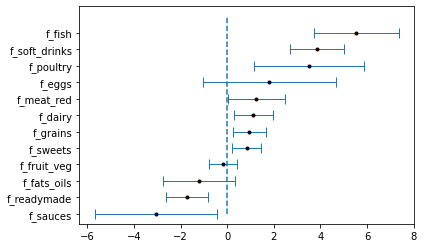

In [25]:
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_1[1:], variables_1[1:], standard_errors_1[1:], p_values_1[1:])))

#fancy plotting

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2);

# Part 2 : Chloropleths maps 

After this Machine Learning part, we want to try to focus on other aspects of our data. Indeed, we have at our disposal a huge dataset containing the food purchases made in the Tesco shops within the boundaries of London. 
We have many features available for the purchases . We notice that the Tesco paper did not deeply explore the different **food categories**. Therefore, we decide to focus on these ones. 

We wonder if the Tesco consumers buy the same category products and in same quantity all over the city. We will try to make maps to answer this questions. In particular, we will make maps of the distribution of a certain food category all over London. We consider a mean of the fraction of purchase of each food category in a given ward.

In [26]:
#Special imports for this parts
import json
import geopandas as gpd
from bokeh.io import output_notebook, show, output_file, curdoc,save, export_png
from bokeh.plotting import figure
from bokeh.models import Slider, HoverTool, GeoJSONDataSource, LinearColorMapper, ColorBar, Dropdown, Select
from bokeh.layouts import widgetbox, row, column, gridplot
from bokeh.palettes import brewer

ModuleNotFoundError: No module named 'geopandas'

### Load the data

In [32]:
# Load the purchases data
df = grocery.copy()

In [34]:
# Load the geographical coordinates of London
fp = Path.cwd() / "data" / "London-wards-2018/London-wards-2018_ESRI/London_Ward.shp"
gdf = gpd.read_file(fp)

AttributeError: module 'pandas' has no attribute 'read_file'

In [35]:
# Load the income data
income_ward = pd.read_csv(Path.cwd() / "data" / "modelled-household-income-estimates-wards.csv", encoding='latin1')

### Preprocessing of the data

In [31]:
# Rename certains columns for the vizualition to be more understandable
df = df.rename(columns={'f_beer':'beer','f_dairy':'dairy','f_eggs':'eggs','f_fats_oils':'fats_oils','f_fish':'fish',
                   'f_fruit_veg':'fruit_veg','f_grains':'grains','f_meat_red':'meat_red','f_poultry':'poultry',
                   'f_readymade':'readymade','f_sauces':'sauces','f_soft_drinks':'soft_drinks','f_spirits':'spirits',
                   'f_sweets':'sweets','f_tea_coffee':'tea_coffee','f_water':'water','f_wine':'wine'})

NameError: name 'df' is not defined

* Clean Income values data

In [36]:
def clean_income_value(income):
    """ Transforms the string '£XX,XXX' into the corresponding integer value XXXXX, if an integer value is given returns it"""
    return int(income[1:].replace(',','')) if type(income) != int else income

In [37]:
# Clean the Dataframe so we can use the values 
years = ['01/02', '02/03', '03/04', '04/05', '05/06', '06/07', '07/08', '08/09', '09/10', '10/11', '11/12', '12/13']
for year in years :
    mean_column = 'Mean 20' + year
    median_column = 'Median 20' + year
    
    # Ward
    income_ward[mean_column] = income_ward[mean_column].map(lambda i : clean_income_value(i) )
    income_ward[median_column] = income_ward[median_column].map(lambda i : clean_income_value(i))

In [38]:
# We only keep data for features of interest
features_of_interest = ['Code', 'Mean 2012/13', 'Median 2012/13']

income_ward_12_13 = income_ward[features_of_interest]

In [39]:
# Rename columns for them to be understand when doing the chloropleth maps
income_ward_12_13 = income_ward_12_13.rename(columns={'Mean 2012/13':'Mean_2012','Median 2012/13':'Median_2012'})
income_ward_12_13.head(5)

,Code,Mean_2012,Median_2012
0,E09000001,99390,63620
1,E05000026,38870,33920
2,E05000027,37290,32470
3,E05000028,37860,33000
4,E05000029,38860,33920


### Join the purchases and income dataframe with the geographical coordinates

In [40]:
# Join the purchases dataframe with the geographical coordinates on the GSS_code (left join to preserve all the gdf rows)
join_df = gdf.join(df.set_index('area_id'), on = 'GSS_CODE', how = 'left')

NameError: name 'gdf' is not defined

In [41]:
# Join the income dataframe with the geographical coordinates on the GSS_code (left join to preserve all the gdf rows)
join_df = join_df.join(income_ward_12_13.set_index('Code'), on = 'GSS_CODE', how = 'left')
join_df.head(5)
null_data = join_df[join_df.isnull().any(axis=1)]
null_data

NameError: name 'join_df' is not defined

In [42]:
# Replace NaN values with the string 'No data'
join_df = join_df.fillna(value='No data')

NameError: name 'join_df' is not defined

### Chloropleth maps helper

In [43]:
def begin_plot(json_data):
    '''begin a plot by initializing the geosource and the palette of colors used'''
    geosource = GeoJSONDataSource(geojson = json_data)
    palette = brewer['YlGnBu'][9]
    palette = palette[::-1]

In [44]:
def make_plot(item):
    '''make a chloropleth map for a certain item (food category in our case)'''
    
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    min_ = min(list(filter(lambda a : a != 'No data', join_df[item].values)))
    max_ = max(list(filter(lambda a : a != 'No data', join_df[item].values)))
    
    color_mapper = LinearColorMapper(palette = palette, low = min_, high = max_, nan_color = '#d9d9d9')
    
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20, border_line_color=None,location = (0,0), orientation = 'horizontal')
    hover = HoverTool(tooltips = [('Region','@NAME'),('% ' + item, '@' + item),('Mean outcome ' ,'$@Mean_2012{,}'),('Median outcome ','$@Median_2012{,}')])

    p = figure(title = 'Fraction of {} in basket'.format(item), plot_height = 400 , plot_width = 470, toolbar_location = None, tools = [hover])
    p.title.text_font = 'helvetica'
    p.title.text_font_style = 'bold'
    p.title.text_font_size = '16px'
    p.title.align = 'center'
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    #Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource,fill_color = {'field' :item, 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)
    
    #Specify figure layout.
    p.add_layout(color_bar, 'below')
    
    #Display figure inline in Jupyter Notebook.
    p.xaxis.visible = False
    p.yaxis.visible = False
    return p

In [45]:
def update_plot(attr, old, new):
    '''update the plot for the case of an interactive map with a selecter'''
    # The input item is the category selected from the select box
    item = select.value
    
    # Update the plot based on the changed inputs
    p = make_plot(item)
    
    # Update the layout, clear the old document and display the new document
    layout = column(p, widgetbox(select))
    curdoc().clear()
    curdoc().add_root(layout)
    geosource.geojson = json_data
    

### Chloropleth Maps 

* Make an interactive map with a selector with represent the fraction of purchases of all food categories in London

    To see it, run the next cell, open a terminal and write "bokeh serve --show InteractiveMap.ipynb", you should see the interactive map on a html page and you could change the category of food selected. It needs that you have the last version of geopandas installed.

In [46]:
# Read data to json.
merged_json = json.loads(join_df.to_json())

# Convert to String like object.
json_data = json.dumps(merged_json)

#Input geojson source and initial category depicted
geosource = GeoJSONDataSource(geojson = json_data)
input_field = 'beer'
palette = brewer['YlGnBu'][9]

#Reverse color order so that dark blue is highest fraction of the category.
palette = palette[::-1]
    
# Call the plotting function
p = make_plot(input_field)

# Make a selection object: select
select = Select(title='Select Categories:', value='beer', options=['beer','dairy','eggs','fats_oils','fish',
                                                                     'fruit_veg','grains','meat_red','poultry',
                                                                     'readymade','sauces','soft_drinks','spirits',
                                                                     'sweets','tea_coffee','water','wine'])
select.on_change('value', update_plot)

# Make a column layout of widgetbox(select) and plot, and add it to the current document
layout = column(p, widgetbox(select))
curdoc().add_root(layout)

# Display the current document
output_notebook()
show(layout)


NameError: name 'json' is not defined

* Make one plot per category 

Each plot below represents the mean proportion of purchase of a certain food category per ward.

In [47]:
begin_plot(json_data)
p_meat_red = make_plot('meat_red')
begin_plot(json_data)
p_beer = make_plot('beer')
begin_plot(json_data)
p_fruit_veg = make_plot('fruit_veg')
begin_plot(json_data)
p_eggs = make_plot('eggs')
begin_plot(json_data)
p_sweets = make_plot('sweets')
begin_plot(json_data)
p_poultry = make_plot('poultry')
begin_plot(json_data)
p_readymade = make_plot('readymade')
begin_plot(json_data)
p_soft_drinks = make_plot('soft_drinks')
begin_plot(json_data)
p_spirits = make_plot('spirits')
begin_plot(json_data)
p_sauces = make_plot('sauces')
begin_plot(json_data)
p_grains = make_plot('grains')
begin_plot(json_data)
p_tea_coffee = make_plot('tea_coffee')
begin_plot(json_data)
p_fish = make_plot('fish')
begin_plot(json_data)
p_fat_oils = make_plot('fats_oils')
begin_plot(json_data)
p_water = make_plot('water')
begin_plot(json_data)
p_wine = make_plot('wine')
begin_plot(json_data)
p_dairy = make_plot('dairy')

layout = gridplot([[p_meat_red,p_beer,p_fruit_veg, p_eggs], [p_sweets, p_poultry,p_readymade, p_soft_drinks],
                  [p_spirits,p_sauces,p_grains,p_tea_coffee],[p_fish,p_fat_oils,p_water,p_wine],[p_dairy]])
curdoc().add_root(layout)
output_notebook()
show(layout)

# Next useful when you want to save the file
#output_file("maps.html") 
#save(layout)

NameError: name 'json_data' is not defined

    Observations : We see that the distributions of proportion of purchases of food category are pretty different. Some food categories shows uniform distributions whereas some others show very disparate distributions. For instance, the comsuption of beer, soft drinks and tea/coffee seem to be the same all over the city. In contrary, the consumption of meat is 6 times higher in the northern and centered wards of London compared to some southern ward. We observe almost the same thing for the poultry. The distribution of ready made, sweets and grains seem to be more important in the southern, eastern and western edge of the city. It is particularly true for ready made where the consumption of this category is almost 50 time higher between some edge parts and some city centered parts.

* Make plots for the mean income and the median income

In [48]:
# Make plot for the income
def make_plot_income(item):
    '''make a chloropleth map for a certain item (food category in our case)'''
    
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    min_ = min(list(filter(lambda a : a != 'No data', join_df[item].values)))
    max_ = max(list(filter(lambda a : a != 'No data', join_df[item].values)))
    
    color_mapper = LinearColorMapper(palette = palette, low = min_, high = max_, nan_color = '#d9d9d9')
    
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20, border_line_color=None,location = (0,0), orientation = 'horizontal')
    hover = HoverTool(tooltips = [('Region','@NAME'),(item, '$@' + item + '{,}')])

    p = figure(title = 'Fraction of {} in basket'.format(item), plot_height = 400 , plot_width = 470, toolbar_location = None, tools = [hover])
    p.title.text_font = 'helvetica'
    p.title.text_font_style = 'bold'
    p.title.text_font_size = '16px'
    p.title.align = 'center'
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    #Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource,fill_color = {'field' :item, 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)
    
    #Specify figure layout.
    p.add_layout(color_bar, 'below')
    
    #Display figure inline in Jupyter Notebook.
    p.xaxis.visible = False
    p.yaxis.visible = False
    return p

In [49]:
begin_plot(json_data)
p_mean = make_plot_income('Mean_2012')
begin_plot(json_data)
p_median = make_plot_income('Median_2012')
layout = gridplot([[p_mean,p_median]])
curdoc().add_root(layout)
output_notebook()
show(layout)
#Next useful to save
#output_file("income.html") 
#save(layout)

NameError: name 'json_data' is not defined

# Part 3 : Link between groceries and income

    Intrigued by the last observations, we will try to see here if there exist a correlation between the income of people and the proportion of purchases of some food category in the Tesco shops for Ward, MSOA and LSOA.

### Data Cleaning

In [50]:
# Load Data 
groceries_ward = grocery.copy()
groceries_msoa = pd.read_csv(Path.cwd() / "data" / "year_msoa_grocery.csv")
groceries_lsoa = pd.read_csv(Path.cwd() / "data" / "year_lsoa_grocery.csv")
income_msoa = pd.read_csv(Path.cwd() / "data" / "modelled-household-income-estimates-msoa.csv", encoding='latin1')
income_lsoa = pd.read_csv(Path.cwd() / "data" / "modelled-household-income-estimates-lsoa.csv", encoding='latin1')


In [51]:
print(f'We have Shopping data for {len(groceries_ward)} Wards, {len(groceries_msoa)} MSOAs and {len(groceries_lsoa)} LSOAs')
print(f'We have Income data for {len(income_ward)} Wards, {len(income_msoa)} MSOAs and {len(income_lsoa)} LSOAs')


We have Shopping data for 638 Wards, 983 MSOAs and 4833 LSOAs
We have Income data for 625 Wards, 983 MSOAs and 4835 LSOAs


In [52]:
# Clean the Dataframe so we can use the values 
for year in years :
    mean_column = 'Mean 20' + year
    median_column = 'Median 20' + year
    # MSOA
    income_msoa[mean_column] = income_msoa[mean_column].map(lambda i : clean_income_value(i) )
    income_msoa[median_column] = income_msoa[median_column].map(lambda i : clean_income_value(i))
    # LSOA
    income_lsoa[mean_column] = income_lsoa[mean_column].map(lambda i : clean_income_value(i) )
    income_lsoa[median_column] = income_lsoa[median_column].map(lambda i : clean_income_value(i))
    
income_msoa.head()

,Code,Name,LAD code,Borough,Mean 2001/02,Mean 2002/03,Mean 2003/04,Mean 2004/05,Mean 2005/06,Mean 2006/07,...,Median 2003/04,Median 2004/05,Median 2005/06,Median 2006/07,Median 2007/08,Median 2008/09,Median 2009/10,Median 2010/11,Median 2011/12,Median 2012/13
0,E02000001,City of London 001,E09000001,City of London,65120,66410,69800,74510,76200,81300,...,45150,48070,48380,51410,53110,54960,57520,59240,62290,63620
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,24900,25210,26370,28050,28630,30520,...,23080,24510,24640,26180,27060,28030,29380,30310,31920,32660
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,30120,30420,31700,33610,34170,36270,...,27880,29500,29540,31250,32160,33160,34610,35540,37270,37970
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,30700,31010,32330,34280,34850,37010,...,28420,30070,30120,31870,32800,33830,35310,36270,38040,38770
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,26280,26670,27930,29740,30380,32400,...,24530,26080,26240,27880,28820,29840,31270,32240,33930,34690


### Data visualization

<ipython-input-131-ae113bfe9147>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(labels=mean_columns, rotation=90)
<ipython-input-131-ae113bfe9147>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(labels=median_columns, rotation=90)
<ipython-input-131-ae113bfe9147>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(labels=mean_columns, rotation=90)
<ipython-input-131-ae113bfe9147>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(labels=median_columns, rotation=90)
<ipython-input-131-ae113bfe9147>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2,0].set_xticklabels(labels=mean_columns, rotation=90)
<ipython-input-131-ae113bfe9147>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2,1].se

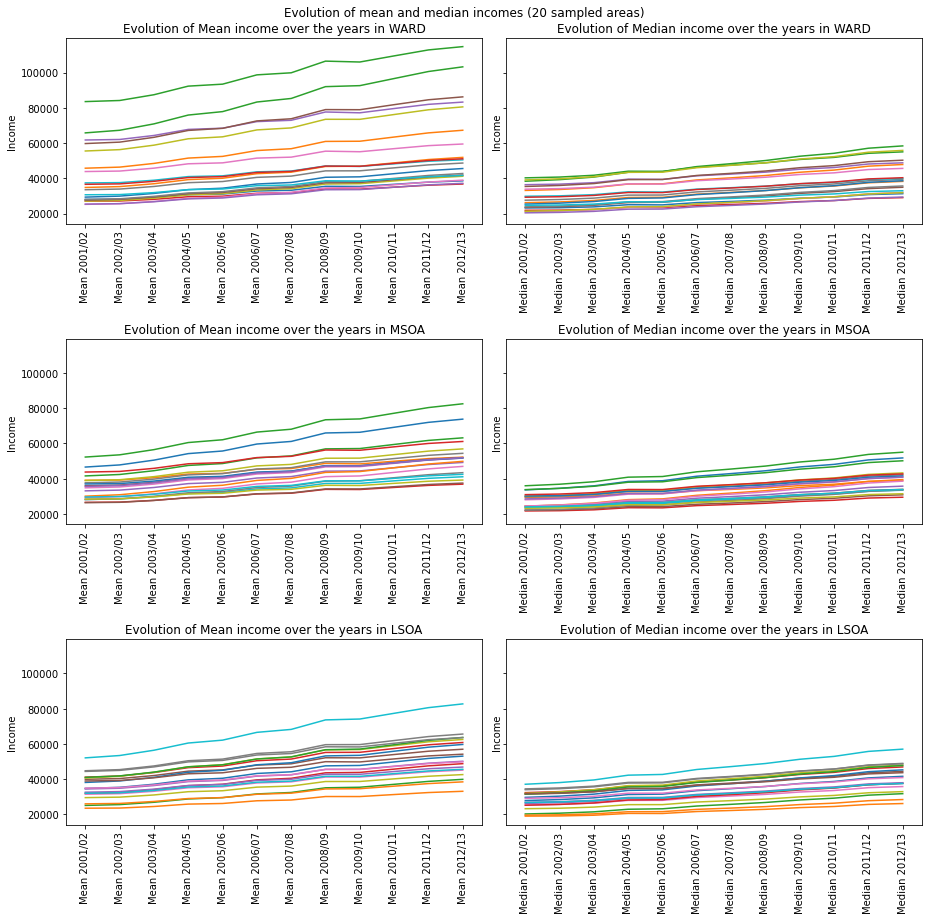

In [131]:
mean_columns = ['Mean 20' + year for year in years]
median_columns = ['Median 20' + year for year in years]

fig, axes = plt.subplots(3,2, figsize=(13,13), sharey=True)
ward_sample = np.random.choice(range(len(income_ward)), 20, replace=False)
msoa_sample = np.random.choice(range(len(income_msoa)), 20, replace=False)
lsoa_sample = np.random.choice(range(len(income_lsoa)), 20, replace=False)

for i in ward_sample:
    axes[0,0].plot(pd.DataFrame(income_ward.iloc[i][mean_columns]))
    axes[0,0].set_xticklabels(labels=mean_columns, rotation=90)
    axes[0,0].set_title('Evolution of Mean income over the years in WARD')
    axes[0,1].plot(pd.DataFrame(income_ward.iloc[i][median_columns]))
    axes[0,1].set_xticklabels(labels=median_columns, rotation=90)
    axes[0,1].set_title('Evolution of Median income over the years in WARD')
    
for i in msoa_sample:
    axes[1,0].plot(pd.DataFrame(income_msoa.iloc[i][mean_columns]))
    axes[1,0].set_xticklabels(labels=mean_columns, rotation=90)
    axes[1,0].set_title('Evolution of Mean income over the years in MSOA')
    axes[1,1].plot(pd.DataFrame(income_msoa.iloc[i][median_columns]))
    axes[1,1].set_xticklabels(labels=median_columns, rotation=90)
    axes[1,1].set_title('Evolution of Median income over the years in MSOA')
    
for i in lsoa_sample:
    axes[2,0].plot(pd.DataFrame(income_lsoa.iloc[i][mean_columns]))
    axes[2,0].set_xticklabels(labels=mean_columns, rotation=90)
    axes[2,0].set_title('Evolution of Mean income over the years in LSOA')
    axes[2,1].plot(pd.DataFrame(income_lsoa.iloc[i][median_columns]))
    axes[2,1].set_xticklabels(labels=median_columns, rotation=90)
    axes[2,1].set_title('Evolution of Median income over the years in LSOA')

    plt.suptitle('Evolution of mean and median incomes (20 sampled areas)')
    
for ay in axes:
    for ax in ay:
        ax.set_ylabel('Income')
plt.tight_layout()

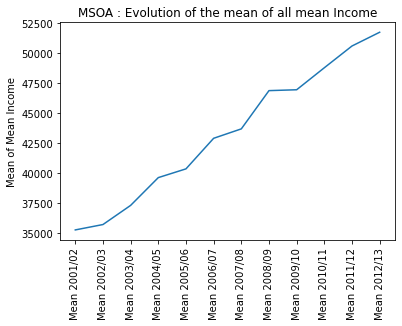

In [132]:
plt.plot(income_msoa.mean()[mean_columns])
plt.xticks(rotation=90)
plt.title('MSOA : Evolution of the mean of all mean Income')
plt.ylabel('Mean of Mean Income')
plt.show()

So first we are interested in seeing how the Mean and Median income evolves between the years. 

As we can see on the graph above, there are some outliers but we can see that overall the Mean and Median outcome tend to go up ! 

We also see that the overall mean income also tends to go up. The same behaviour is observed for Ward, MSOA or LSOA

We decide to use the revenue for year 2012/13 as it is the closest data we have to 2015. Note that since we see a tendency to going growing, we can assume that an overall increasing trend is to be exected. 

We could find a regressor to find an expected value for 2014/15 

### Correlation between Groceries propostions and Income

In [70]:
# We only keep data for features of interest
features_of_interest = ['Code', 'Mean 2012/13', 'Median 2012/13']

income_ward_12_13 = income_ward[features_of_interest]
income_msoa_12_13 = income_msoa[features_of_interest]
income_lsoa_12_13 = income_lsoa[features_of_interest]

# Join the Income Data on the corresponding Shopping Data 

groceries_income_ward = groceries_ward.join(income_ward_12_13.set_index('Code'),on='area_id',how='inner').rename(columns={'Mean 2012/13': 'mean_income', 'Median 2012/13': 'median_income'})
groceries_income_msoa = groceries_msoa.join(income_msoa_12_13.set_index('Code'),on='area_id',how='inner').rename(columns={'Mean 2012/13': 'mean_income', 'Median 2012/13': 'median_income'})
groceries_income_lsoa = groceries_lsoa.join(income_lsoa_12_13.set_index('Code'),on='area_id',how='inner').rename(columns={'Mean 2012/13': 'mean_income', 'Median 2012/13': 'median_income'})

groceries_income_msoa.head()

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,mean_income,median_income
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069,99390,63620
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704,37490,32660
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794,43440,37970
3,E02000004,347.481292,29.0,126.0,250.0,430.0,1000.0,479.372575,5.297349,104.435407,...,3119.0,3417.0,1454.0,4044.0,1038.0,38.493115,2.48,2635.483871,44370,38770
4,E02000005,400.576688,32.5,150.0,296.0,500.0,1050.0,593.021809,5.107669,128.997438,...,4478.0,4765.0,2678.0,5554.0,1011.0,34.156335,1.19,7767.226891,39710,34690


In [72]:
categories_fraction = ['f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red', 
                       'f_poultry', 'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 
                       'f_water', 'f_wine']

nutrients_fraction = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                      'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot']

groceries_dfs = [('ward', groceries_income_ward), 
                 ('msoa', groceries_income_msoa), 
                 ('lsoa', groceries_income_lsoa)]

def compute_correlations_categories_incomes(df, income, categories=categories_fraction):
    r_values = []
    p_values = []
    category = []

    for cat in categories:
        correl, p_value = stats.spearmanr(df[cat],df[income])
        #print(f"- {cat} : {correl} with p-value {p_value}")
        r_values.append(correl)
        p_values.append(p_value)
        category.append(cat)


    correlation_df = pd.DataFrame({'Category' : category, 'R': r_values, 'p': p_values, 'statistically_significant' : [ p < 0.05 for p in p_values]})
    correlation_df
    
    return correlation_df

def compute_correlations_categories_incomes_list(dfs, income, categories=categories_fraction):
    correlation_df = pd.DataFrame({'Category' : categories})
    for name, df in dfs:
        r_values = []
        p_values = []

        for cat in categories:
            correl, p_value = stats.spearmanr(df[cat],df[income])
            #print(f"- {cat} : {correl} with p-value {p_value}")
            r_values.append(correl)
            p_values.append(p_value)

        correlation_df['R_'+name] = r_values
        correlation_df['p_'+name] = p_values
        correlation_df['stat_'+name] = [ p < 0.05 for p in p_values]
    
    return correlation_df

def compute_correlations_categories_incomes_grouped(dfs, income, categories=categories_fraction, category_name = 'category'):
    r_values = []
    p_values = []
    census = []
    for name, df in dfs:
        for cat in categories:
            correl, p_value = stats.spearmanr(df[cat],df[income])
            #print(f"- {cat} : {correl} with p-value {p_value}")
            r_values.append(correl)
            p_values.append(p_value)
            census.append(name)

    correlation_df = pd.DataFrame({category_name : categories * len(dfs), 'census': census, 'R': r_values, 'p': p_values, 'stat_sig' : [ p < 0.05 for p in p_values]})

    return correlation_df.groupby([category_name,'census']).sum()


In [73]:
# Computes the correlation between Mean Income in 2012/13 and the food categories ! 
correlation_all_census = compute_correlations_categories_incomes_grouped(dfs=groceries_dfs, income='mean_income')
correlation_all_census

R              p  stat_sig
category      census                                   
f_beer        lsoa    0.241147   6.712715e-65         1
              msoa    0.329865   2.209742e-26         1
              ward    0.401195   4.195477e-20         1
f_dairy       lsoa    0.091833   1.594078e-10         1
              msoa    0.132492   3.085086e-05         1
              ward    0.119722   8.443079e-03         1
f_eggs        lsoa    0.028132   5.050759e-02         0
              msoa    0.027963   3.811476e-01         0
              ward    0.013389   7.691430e-01         0
f_fats_oils   lsoa   -0.183435   7.721687e-38         1
              msoa   -0.215937   7.782019e-12         1
              ward   -0.252480   1.846039e-08         1
f_fish        lsoa    0.253897   5.632976e-72         1
              msoa    0.296938   1.845575e-21         1
              ward    0.290188   7.955804e-11         1
f_fruit_veg   lsoa    0.597351   0.000000e+00         1
              msoa    0.650042  4.106388e-119         1
              ward    0.679052   1.423276e-66         1
f_grains      lsoa   -0.457072  3.615007e-248         1
              msoa   -0.502994   3.682390e-64         1
              ward   -0.517392   2.008923e-34         1
f_meat_red    lsoa   -0.074594   2.084255e-07         1
              msoa   -0.072950   2.217616e-02         1
              ward   -0.095344   3.619338e-02         1
f_poultry     lsoa    0.000390   9.783816e-01         0
              msoa   -0.008226   7.967309e-01         0
              ward   -0.028251   5.356600e-01         0
f_readymade   lsoa   -0.037013   1.007233e-02         1
              msoa   -0.021158   5.075946e-01         0
              ward   -0.000089   9.984484e-01         0
f_sauces      lsoa   -0.000909   9.496522e-01         0
              msoa   -0.011878   7.099363e-01         0
              ward   -0.010733   8.139962e-01         0
f_soft_drinks lsoa   -0.612271   0.000000e+00         1
              msoa   -0.682148  1.581922e-135         1
              ward   -0.703869   1.838281e-73         1
f_spirits     lsoa   -0.300546  1.850425e-101         1
              msoa   -0.448386   8.681138e-50         1
              ward   -0.517000   2.296259e-34         1
f_sweets      lsoa   -0.447342  1.485453e-236         1
              msoa   -0.495276   5.735457e-62         1
              ward   -0.519211   1.076634e-34         1
f_tea_coffee  lsoa   -0.195203   1.030433e-42         1
              msoa   -0.282885   1.519790e-19         1
              ward   -0.306966   5.350043e-12         1
f_water       lsoa   -0.627915   0.000000e+00         1
              msoa   -0.733513  1.066356e-166         1
              ward   -0.763828   1.626275e-93         1
f_wine        lsoa    0.618267   0.000000e+00         1
              msoa    0.736352  1.240220e-168         1
              ward    0.764709   7.455158e-94         1

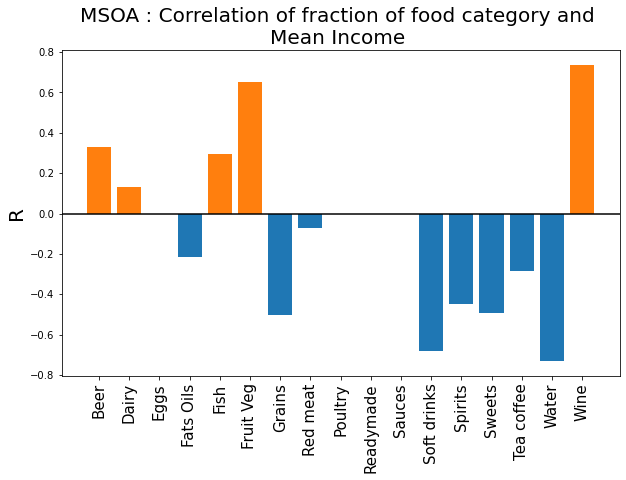

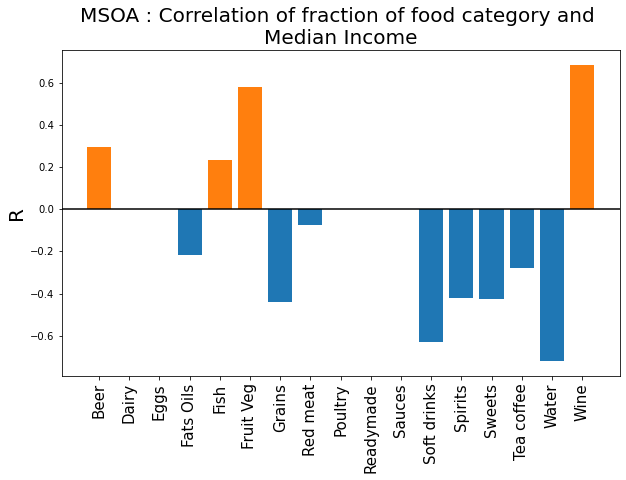

In [74]:

categories_labels = ['Beer', 'Dairy', 'Eggs', 'Fats Oils', 'Fish', 'Fruit Veg', 'Grains', 'Red meat', 
                       'Poultry', 'Readymade', 'Sauces', 'Soft drinks', 'Spirits', 'Sweets', 'Tea coffee', 
                       'Water', 'Wine']

correlation_msoa = compute_correlations_categories_incomes(df=groceries_income_msoa, income='mean_income')

fig = plt.figure(figsize=(10,6))
plt.title('MSOA : Correlation of fraction of food category and \nMean Income ', fontsize=20)
plt.bar(correlation_msoa.Category,correlation_msoa.R, color = [ 'white' if not v[3] else'tab:orange' if v[1] > 0 else 'tab:blue' for v in correlation_msoa.values])
plt.xticks(correlation_msoa.Category,categories_labels, rotation='vertical',fontsize=15)
plt.axhline(y=0,color='black') 
plt.ylabel('R',fontsize=20)
plt.show()

correlation_msoa = compute_correlations_categories_incomes(df=groceries_income_msoa, income='median_income')

fig = plt.figure(figsize=(10,6))
plt.title('MSOA : Correlation of fraction of food category and \nMedian Income', fontsize=20)
plt.bar(correlation_msoa.Category,correlation_msoa.R, color = [ 'white' if not v[3] else'tab:orange' if v[1] > 0 else 'tab:blue' for v in correlation_msoa.values])
plt.xticks(correlation_msoa.Category,categories_labels, rotation='vertical',fontsize=15)
plt.axhline(y=0,color='black') 
plt.ylabel('R',fontsize=20)
plt.show()


Index(['Category', 'R', 'p', 'statistically_significant'], dtype='object')


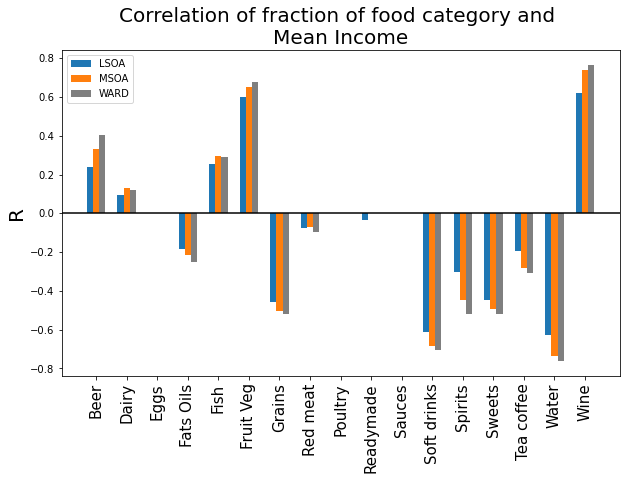

In [75]:
def color_sts(df, color): 
    return [ 'white' if not v else color for v in df.statistically_significant.values]

correlation_msoa = compute_correlations_categories_incomes(df=groceries_income_msoa, income='mean_income')
correlation_lsoa = compute_correlations_categories_incomes(df=groceries_income_lsoa, income='mean_income')
correlation_ward = compute_correlations_categories_incomes(df=groceries_income_ward, income='mean_income')

print(correlation_msoa.columns)
width = 0.2
x = np.arange(len(categories_labels))
fig = plt.figure(figsize=(10,6))
plt.title('Correlation of fraction of food category and \nMean Income', fontsize=20)
plt.bar(x - width,correlation_lsoa.R, width=width, color = color_sts(correlation_lsoa,'tab:blue'), label='LSOA')
plt.bar(x, correlation_msoa.R, width=width, color = color_sts(correlation_msoa,'tab:orange'), label='MSOA')
plt.bar(x + width,correlation_ward.R, width=width, color = color_sts(correlation_ward,'tab:grey'), label='WARD')
plt.xticks(x ,categories_labels, rotation='vertical',fontsize=15)
plt.axhline(y=0,color='black') 
plt.ylabel('R',fontsize=20)
plt.legend()
plt.show()

So here first we compute the correlations between the percentage of each food category and the mean income. Note that we obtain similar values with median(we display data below). We thus can conduct the same analysis on both dataframes and choose to do it on this one.  


First it's worth noting what these correlations mean. A positive correlation means that having a greater fraction of all the products belonging to a category relates to a higher Mean Income.
So it does not mean that people with high revenues don't buy any product of a negatively correlated category or even that they buy less. It means that the fraction of their shopping bag item belonging to that category is smaller. 
Taking the example of grains, this category being negatively correlated with income means that people with lower income overall have a bigger part of their alimentation composed of grains. 

So let's analyse these results. 
- The negatives correlation of Income with  Sweets, Spirits, Soft Drinks, Fats Oils and Grains is quite interesting because it shows that poorer neighbourhood show a higher part of the groceries dedicated to less healthy food. The correlation with spirits is also quite interesting as it might induce that poorer neighbourhood might be more prone to alcoholism or at least a higher consumption of stronger alcohol. 

- The positive correlation of Income with Fruit and Vegetables, Fish and Dairy product is also quite interesting as we here find that 'healthier' products take a bigger part of the shopping bag in areas where the income is higher. Fruit and vegetables can also be explained as people with higher incomes might be more prone to be vegetarian. Wine is also one of those positively correlated food categories and we can explain that as wine being a 'fancy drink'. 

- The fraction of water being negatively correlated with water seems quite surprising at first but we can actually make a point by finding that tap water in poorer neighbouhoods might be of lower quality forcing people there to buy more bottled water. People in richer neighbourhood might also be more likely to buy a water filtering system. It might also be that people might tend to buy big packs of water bottles in huge malls situated in industrial areas where the global Income might be lower and thus correlating it with lower Income.

- Fraction of tea and coffee being negatively correlated with income is not very, so is the positive one with beer. 

- We let aside the correlation that are not statistically significant or very low, namely eggs, poultry, red meat and ready-made food. Although for the latter, we can suppose that any worker is sensible to buying ready-made food for lunch thus it does not really correlates with the Income. 

Important to qualify these remarks : 

- The people buying food in a given area don't necessarily live in the area. 

- It might be that some big shopping center are situated in industrial places outside the city, thus not much people live there so the mean income would be quite low even though all sorts of people go shopping there. 

- We also can note that areas with really high median incomes might not be the most populated ones (finacial districts ... ) and might also not be the shopping place of a lot of people. Thus this most likely gives skewed data.

We now address some of these questions by looking at the relationship between the population of an area and its Mean Income. 

In [76]:
# Population
print(stats.spearmanr(groceries_income_msoa['population'],groceries_income_msoa['median_income']))
print(stats.spearmanr(groceries_income_msoa['population'],groceries_income_msoa['mean_income']))

# People Density 
print(stats.spearmanr(groceries_income_msoa['people_per_sq_km'],groceries_income_msoa['median_income']))
print(stats.spearmanr(groceries_income_msoa['people_per_sq_km'],groceries_income_msoa['mean_income']))

SpearmanrResult(correlation=-0.20045015788247775, pvalue=2.2805751348733914e-10)
SpearmanrResult(correlation=-0.1972479719125363, pvalue=4.437811460105744e-10)
SpearmanrResult(correlation=-0.13931343135444504, pvalue=1.1667698939963852e-05)
SpearmanrResult(correlation=-0.028859639032964624, pvalue=0.3660652019584485)


Negative correlation so areas more populated tend to have a lower mean and median income.

In [77]:
compute_correlations_categories_incomes_grouped(dfs=groceries_dfs, income='median_income')

R              p  stat_sig
category      census                                   
f_beer        lsoa    0.221357   1.022171e-54         1
              msoa    0.295807   2.656709e-21         1
              ward    0.382551   2.794284e-18         1
f_dairy       lsoa    0.033948   1.826735e-02         1
              msoa    0.053144   9.586115e-02         0
              ward    0.039917   3.813880e-01         0
f_eggs        lsoa   -0.037049   9.999073e-03         1
              msoa   -0.048691   1.271189e-01         0
              ward   -0.049929   2.734549e-01         0
f_fats_oils   lsoa   -0.189450   2.730800e-40         1
              msoa   -0.217491   5.464655e-12         1
              ward   -0.242299   6.974651e-08         1
f_fish        lsoa    0.200586   4.734918e-45         1
              msoa    0.234188   1.031700e-13         1
              ward    0.235429   1.655034e-07         1
f_fruit_veg   lsoa    0.536216   0.000000e+00         1
              msoa    0.580207   1.620123e-89         1
              ward    0.612771   3.975540e-51         1
f_grains      lsoa   -0.401310  1.740485e-186         1
              msoa   -0.438276   2.113256e-47         1
              ward   -0.457445   2.369577e-26         1
f_meat_red    lsoa   -0.074784   1.940799e-07         1
              msoa   -0.073419   2.133057e-02         1
              ward   -0.083536   6.660403e-02         0
f_poultry     lsoa   -0.005377   7.085997e-01         0
              msoa   -0.018393   5.646230e-01         0
              ward   -0.029472   5.181677e-01         0
f_readymade   lsoa    0.015154   2.922064e-01         0
              msoa    0.034034   2.864193e-01         0
              ward    0.045637   3.168734e-01         0
f_sauces      lsoa   -0.002250   8.757545e-01         0
              msoa   -0.013499   6.725114e-01         0
              ward    0.011421   8.023102e-01         0
f_soft_drinks lsoa   -0.573987   0.000000e+00         1
              msoa   -0.632284  7.321449e-111         1
              ward   -0.668482   7.667645e-64         1
f_spirits     lsoa   -0.284188   1.838452e-90         1
              msoa   -0.421735   1.147389e-43         1
              ward   -0.485348   6.538090e-30         1
f_sweets      lsoa   -0.391258  1.468349e-176         1
              msoa   -0.426821   8.576898e-45         1
              ward   -0.452808   8.609118e-26         1
f_tea_coffee  lsoa   -0.202718   5.372527e-46         1
              msoa   -0.278016   6.616976e-19         1
              ward   -0.310602   2.911649e-12         1
f_water       lsoa   -0.622212   0.000000e+00         1
              msoa   -0.722823  1.244283e-159         1
              ward   -0.769943   6.749103e-96         1
f_wine        lsoa    0.579559   0.000000e+00         1
              msoa    0.685892  1.401379e-137         1
              ward    0.717980   1.042219e-77         1

In [78]:
# Check for area with representativeness_norm > threshold

threshold = 0.3
groceries_rep_dfs = [('ward', groceries_income_ward[groceries_income_ward['representativeness_norm'] > threshold]), 
                 ('msoa', groceries_income_msoa[groceries_income_msoa['representativeness_norm'] > threshold]), 
                 ('lsoa', groceries_income_lsoa[groceries_income_lsoa['representativeness_norm'] > threshold])]

correlation_all_census_rep_02 = compute_correlations_categories_incomes_grouped(dfs=groceries_rep_dfs, income='mean_income')
correlation_all_census_rep_02

R              p  stat_sig
category      census                                   
f_beer        lsoa    0.263473   2.326872e-13         1
              msoa    0.336522   3.360654e-14         1
              ward    0.403552   4.469267e-12         1
f_dairy       lsoa    0.152805   2.673312e-05         1
              msoa    0.145197   1.407670e-03         1
              ward    0.129475   3.280064e-02         1
f_eggs        lsoa   -0.049118   1.793307e-01         0
              msoa    0.018842   6.801955e-01         0
              ward   -0.035850   5.560492e-01         0
f_fats_oils   lsoa   -0.313588   1.488025e-18         1
              msoa   -0.299768   1.915974e-11         1
              ward   -0.401643   5.751592e-12         1
f_fish        lsoa    0.237403   4.683510e-11         1
              msoa    0.344593   7.407493e-15         1
              ward    0.283065   2.092185e-06         1
f_fruit_veg   lsoa    0.731399  2.592154e-126         1
              msoa    0.767856   1.091357e-94         1
              ward    0.755543   1.619035e-51         1
f_grains      lsoa   -0.656126   2.107329e-93         1
              msoa   -0.680855   8.853886e-67         1
              ward   -0.669172   1.102318e-36         1
f_meat_red    lsoa   -0.242724   1.665609e-11         1
              msoa   -0.128220   4.856441e-03         1
              ward   -0.132529   2.886665e-02         1
f_poultry     lsoa   -0.192912   1.032906e-07         1
              msoa   -0.109440   1.634238e-02         1
              ward   -0.095460   1.162516e-01         0
f_readymade   lsoa   -0.042765   2.424218e-01         0
              msoa    0.004303   9.250150e-01         0
              ward    0.063698   2.952107e-01         0
f_sauces      lsoa   -0.054273   1.378230e-01         0
              msoa    0.020406   6.552892e-01         0
              ward    0.046948   4.406190e-01         0
f_soft_drinks lsoa   -0.714815  3.806805e-118         1
              msoa   -0.761055   4.410326e-92         1
              ward   -0.742754   5.992884e-49         1
f_spirits     lsoa   -0.298030   7.887347e-17         1
              msoa   -0.461211   1.041999e-26         1
              ward   -0.536425   1.142110e-21         1
f_sweets      lsoa   -0.559416   6.796131e-63         1
              msoa   -0.582185   5.527587e-45         1
              ward   -0.598202   8.660556e-28         1
f_tea_coffee  lsoa   -0.233344   1.013501e-10         1
              msoa   -0.334066   5.278789e-14         1
              ward   -0.336133   1.312983e-08         1
f_water       lsoa   -0.699597  3.771091e-111         1
              msoa   -0.782478  1.317654e-100         1
              ward   -0.801453   3.175887e-62         1
f_wine        lsoa    0.651424   1.171398e-91         1
              msoa    0.747590   3.595970e-87         1
              ward    0.763862   2.830457e-53         1

We can see that even if we take the areas where representativeness_norm > 0.3, the correlation stay more or less the same.

In [83]:
# Computes the correlation between Mean Income in 2012/13 and the energy from nutients  ! 
compute_correlations_categories_incomes_grouped(dfs=groceries_dfs, income='mean_income', categories=nutrients_fraction, category_name='nutrient')
correlation_nutrients = compute_correlations_categories_incomes(groceries_income_msoa, income='mean_income', categories=nutrients_fraction)
correlation_nutrients

,Category,R,p,statistically_significant
0,energy_fat,-0.296053,2.454642e-21,True
1,energy_saturate,-0.142765,7.008351e-06,True
2,energy_sugar,-0.424983,2.201584e-44,True
3,energy_protein,0.344536,8.861380e-29,True
4,energy_carb,-0.581642,4.703541e-90,True
5,energy_fibre,0.651744,6.216726e-120,True
6,energy_alcohol,0.468979,6.633793e-55,True
7,energy_tot,-0.501191,1.211114e-63,True


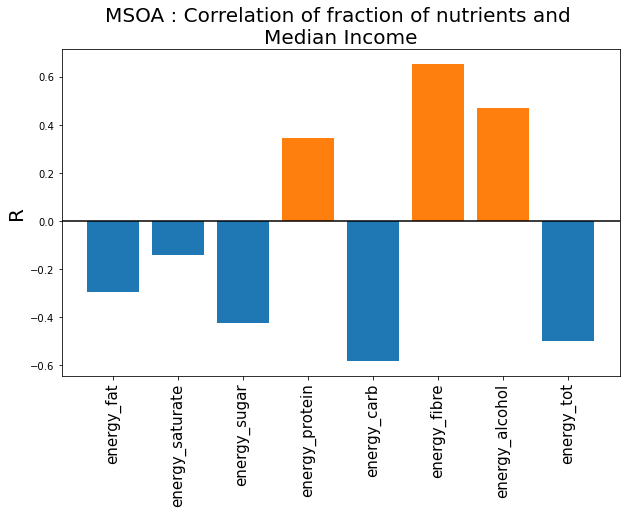

In [84]:
fig = plt.figure(figsize=(10,6))
plt.title('MSOA : Correlation of fraction of nutrients and \nMedian Income', fontsize=20)
plt.bar(correlation_nutrients.Category, correlation_nutrients.R, color = [ 'white' if not v[3] else'tab:orange' if v[1] > 0 else 'tab:blue' for v in correlation_nutrients.values])
plt.xticks(correlation_nutrients.Category,nutrients_fraction, rotation='vertical',fontsize=15)
plt.axhline(y=0,color='black') 
plt.ylabel('R',fontsize=20)
plt.show()

Makes sense w.r.t. the WHO recommendations.

## Machine learning techniques

So we will first try and fit a linear regressor to predict Mean and Median Income and see how well it performs. 
We keep 70% of our data for training. From the previous correlation studies, we decide to use as features only the columns for which the correlation is statistically significant. 

First we'll study the case for MSOA as it is the middle sized and we can witness the same phenomena for the three areas ! 

Hence we will use for training 
**f_beer, f_dairy, f_fats_oils, f_fish, f_fruit_veg, f_grains, f_meat_red, f_soft_drinks, f_spirits, f_sweets, f_tea_coffee, f_water and f_wine**.

R^2 score in the random split scenario : 0.6345510135295613


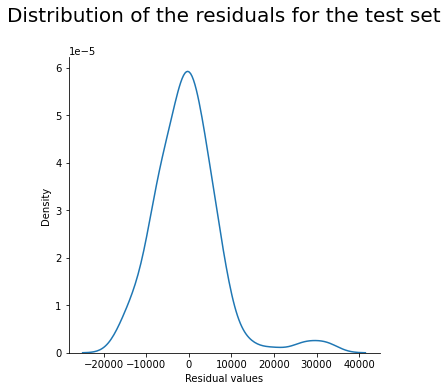

In [111]:

# Split our data for regression 
train, test = model_selection.train_test_split(groceries_income_ward, test_size=0.3)

# Select the parameters columns

columns = ['f_beer', 'f_dairy', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains',
           'f_meat_red', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine']

# Build X and Y for the training set 
X_tr = train[columns]
y_tr = train['mean_income']

# Fit the model 
reg_rd = linear_model.LinearRegression().fit(X_tr, y_tr)

# Build X and Y for the test set
X_te = test[columns]
y_te = test['mean_income']

# Predict using our model and evaluate the R-squared score
y_pred = reg_rd.predict(X_te)
r2 = reg_rd.score(X_te, y_te)
print(f'R^2 score in the random split scenario : {r2}')

residual = y_te - y_pred
lm = sns.displot(residual,kind='kde')
plt.xlabel('Residual values')
plt.title('Distribution of the residuals for the test set', fontsize=20, y=1.1)
plt.show()

In [115]:
# Probability 
def CI_2_points_off(data, nbr_draws):
    """ Bootstrap confidence interval that our regression is off by more than 2 points"""
    percentage = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        percentage[n] = ((data_tmp <= -10000) | (10000 <= data_tmp)).sum() / len(data)
    
    return np.nanpercentile(percentage, 2.5), np.median(percentage), np.nanpercentile(percentage, 97.5)

lower, median, upper = CI_2_points_off(residual, 1000)
print(f'The probability that our prediction is off by more than 10000 pounds is : {median:.5}')
print(f'The confidence interval is : ({lower:.5}, {upper:.5})')

The probability that our prediction is off by more than 10000 pounds is : 0.11724
The confidence interval is : (0.068966, 0.17241)


So we tried Linear Regression first and it already gave a quite high r-squared value. This is inducing that the linear regression using these features allow a good prediction of the Mean Income. 
As we can see, the probability of being off by more than 10000 pounds is quite low. This shows us that on top of being quite accurate, our regression is rarely off by more than 10000 pounds. Thus we can see that the select food categories allow us to get a quite good prediction of the income.  

In [122]:
linear_regression(X_tr, y_tr, X_te, y_te)
ridge_model(X_tr, y_tr, X_te, y_te)
svm_model(X_tr, y_tr, X_te, y_te)
tree_model(X_tr, y_tr, X_te, y_te)
GBR_model(X_tr, y_tr, X_te, y_te)
ADA_model(X_tr, y_tr, X_te, y_te)

Mean squared error: 62613891.251
R2 score: 0.635
coefs [-253610.22627907  -68641.03781222 -374752.74821703  216354.4182865
    3506.84229306 -312595.50105737 -571064.65923921 -377475.50092629
 -117236.17216488  -48370.36676874  418811.5611596  -359269.3663197
  644893.97476572]
A ridge model obtain the best r2 score when the lasso alpha is 0.1. The r2 score is 0.509 and the related mse score is 84207030.272
SVM: Mean squared error: 174253551.298
SVM: R2 score: -0.017
Decision Tree: Mean squared error: 74708535.172
Decision Tree: R2 score: 0.564
Gradient Boosting Regressor: Mean squared error: 69264168.606
Gradient Boosting Regressor::R2 score: 0.596
ADA: Mean squared error: 73683581.381
ADA: R2 score: 0.570


We run several other ML models but found that the linear regression gives the best R-squared score.We thus stick to this regressor for the rest of our analysis. 

Linear Regression R2 score: 0.635


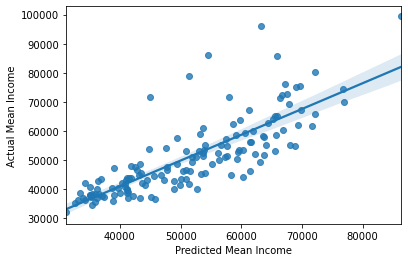

In [119]:
predicted_y = linear_regression(X_tr, y_tr, X_te, y_te)

pd.DataFrame({'Actual_Value': y_te, 'Predicted_Value': predicted_y})

import seaborn as sns 
sns.regplot(x=predicted_y, y=y_te)
plt.xlabel("Predicted Mean Income")
plt.ylabel("Actual Mean Income")
plt.show()

In [120]:
import statsmodels.formula.api as smf
logitfit3 = smf.ols(formula = 'mean_income ~ f_beer + f_dairy + f_fats_oils + f_fish + f_fruit_veg + f_grains + f_meat_red + f_soft_drinks + f_spirits + f_sweets + f_tea_coffee + f_water + f_wine', data = groceries_income_ward).fit()
print(logitfit3.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_income   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     76.24
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          1.08e-106
Time:                        17:32:35   Log-Likelihood:                -5024.3
No. Observations:                 483   AIC:                         1.008e+04
Df Residuals:                     469   BIC:                         1.014e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8.776e+04   6.31e+04      1.391

### TODO 

- Regression Analysis

## Limitations : 

- We are using data for 2012/13 for income Data, even though we can deduce insights thanks to our assumption, having data from 2015 would've been better ! 